In [24]:
import argparse

from utils.logger import get_logger
from utils.arg_parser import Argments
from loader.data_loader import GeneralDataLoaderCls, NbsDataLoaderCls,\
                               GeneralDataLoaderSeg, NbsDataLoaderSeg,NbsDataLoaderRgs
from runners.cnn_runner import CnnRunner
from runners.nbs_runner import NbsRunner
from runners.mcd_runner import McdRunner
from models.regression import Reg_model
import torch
import numpy as np
from tqdm import tqdm
from runners.base_runner import gather_tensor

print(torch.cuda.is_available())

True


In [25]:
Reg_model

models.regression.Reg_model

In [26]:
from models.__init__ import _get_model

In [27]:
model = _get_model('Reg_model','nbs',1)

In [28]:
argparser = argparse.ArgumentParser()
# adding the values
argparser.add_argument("yaml")
argparser.add_argument("--phase", default="train", type=str) 
argparser.add_argument("--index", default=-1, type=int) 
argparser.add_argument("--gpus", default="0", type=str)
argparser.add_argument("--local_rank", default=-1, type=int) 
# save 
cmd_args = argparser.parse_args(["example2"])

arg = Argments(f"scripts/{cmd_args.yaml}.yaml", cmd_args) # stll many funcs to read
setup = arg['setup']
model_path = arg['path/model_path']
logger = get_logger(f"{model_path}/log.txt")

if setup['rank'] == 0:
    logger.info(arg)

model_type = setup['model_type']
dataset = arg['path/dataset']
is_seg = False

if 'nbs' in model_type: # added in n_a (comparing the else loop)
        
    _data_loader = NbsDataLoaderRgs # n_a exists
    data_loader = _data_loader(dataset, setup['batch_size'],
                                setup['n_a'], setup['cpus'], setup['seed'])
    runner = NbsRunner(data_loader, **arg.module, num_epoch=setup['num_epoch'], # core part 
                        logger=logger, model_path=model_path, rank=setup['rank'],
                        epoch_th=setup['epoch_th'], num_mc=setup['num_mc'],
                        adv_training=setup['adv_training'])

setting the python env
cmd_args.local_rank:  -1
torch.Size([1000, 1])
torch.Size([1000, 1])
here1
here3
here4
here2


In [29]:
runner.load('best.pth')
loader = runner.loader.load('test')
if runner.rank == 0:
    t_iter = tqdm(loader, total=runner.loader.len)
else:
    t_iter = loader

outputs = []
metrics = []
inputs = []
runner.model.eval()
for img, label in t_iter:
    _metric, output = runner._valid_a_batch(img, label, with_output=True)
    inputs += img.squeeze().tolist()
    outputs += output.cpu().mean(0).squeeze().tolist() # gather_tensor(output).cpu().numpy()
    metrics += [_metric.cpu().item()] # gather_tensor(_metric).cpu().numpy()
# labels = np.concatenate(labels)
# outputs = np.concatenate(outputs, axis=1)
err = np.mean(metrics[:])
# nll, brier = calc_nll_brier_mc(outputs, labels)
# print("Becarful, the num_class set as 1")
print(f"[Test] loss: {err:.5f} ")
# log += f"NLL : {nll:.2f}, Brier : {brier:.2f}"


[Test] loss: 1.33468 


In [30]:
print(len(labels))
print(len(outputs))

200
200


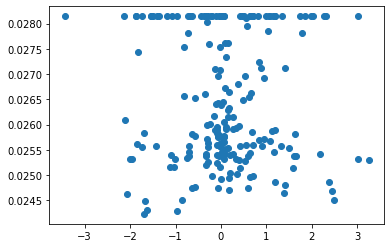

In [31]:
import matplotlib.pyplot as plt
plt.scatter(labels,outputs)
plt.show()

In [32]:
n_train= 1000
n_test = 200

train_step =0.004
test_step = 0.02
start = -2
end = -start

train_X = torch.arange(start,end,train_step)
train_sd = torch.sqrt(train_X**2 + 1e-05)
train_y = torch.normal(torch.zeros(train_X.shape[0]),train_sd)

test_X = torch.arange(start,end,test_step)
test_sd = torch.sqrt(test_X**2 + 1e-05)
test_y = torch.normal(torch.zeros(test_X.shape[0]),test_sd)

train_X = train_X.unsqueeze(1)
train_y = train_y.unsqueeze(1)
test_X = test_X.unsqueeze(1)
test_y = test_y.unsqueeze(1)

# y = torch.normal(torch.zeros(X.shape[0]),sd)
# train_idx = torch.randint(0,100,(n_train,))
# train_X = X[train_idx].unsqueeze(1)
# train_y = y[train_idx].unsqueeze(1)

# test_idx = torch.randint(0,100,(n_test,))
# test_X = X[test_idx].unsqueeze(1)
# test_y = y[test_idx].unsqueeze(1)

# normalize
train_X = (train_X - train_X.mean())/train_X.std()
test_X = (test_X - test_X.mean())/test_X.std()

In [33]:
print(test_X.min())
print(test_X.max())


tensor(-1.7191)
tensor(1.7191)


In [34]:
import pandas as pd
df = pd.DataFrame({"inputs":inputs,"outputs":outputs})

c:\Users\user\.conda\envs\torch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


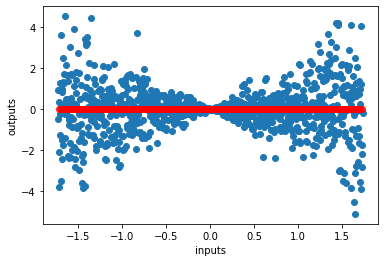

In [35]:
import seaborn as sns

plt.scatter(train_X.squeeze(),train_y.squeeze())
sns.regplot("inputs","outputs",data=df,color="red")
# plt.scatter(inputs,outputs,color="red")
plt.show()